# Canonical Correlation Analysis (CCA) for Emotion Modeling

## Mapping Physiological Features to Self-Reported Emotions Using CCA and Supervised Models

## Aim / Research Question:

How strongly are physiological features correlated with emotional self-assessments? Can we predict emotional scores from biosignals?

## Importing Libraries

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

## Loading Data

In [74]:
data_path = '../data/HR_data.csv'
data = pd.read_csv(data_path)

### Data Wrangling

In [75]:
# Separate X (biosignal features) and Y (emotion responses)
meta_cols = ['Unnamed: 0', 'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']

emotion_cols = [
    'inspired', 'attentive', 'determined','active','alert',
    'Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid'
    ]

feature_cols = [col for col in data.columns if col not in meta_cols + emotion_cols]

In [76]:
# Drop rows with missing values
df = data[feature_cols + emotion_cols].dropna()

# Create new dataframes for features and emotions
X = df[feature_cols].values
Y = df[emotion_cols].values

# Standardize both sets
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# CCA

In [77]:
# Apply Canonical Correlation Analysis
cca = CCA(n_components=3)  # Try 3 canonical components
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

# Compute canonical correlations
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]
print("Canonical correlations:", np.round(canonical_corrs, 3))

Canonical correlations: [0.674 0.57  0.516]


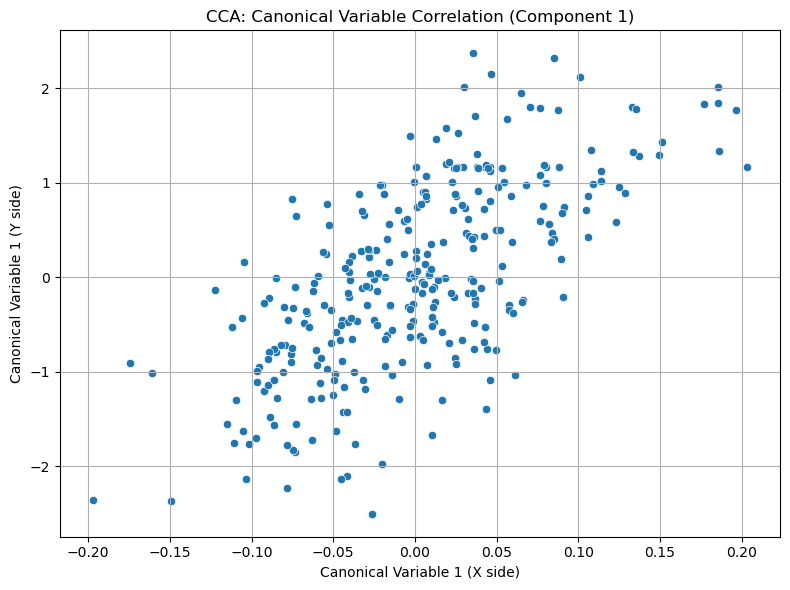

In [78]:
# Visualize Canonical Correlation Pairs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_c[:, 0], y=Y_c[:, 0])
plt.xlabel("Canonical Variable 1 (X side)")
plt.ylabel("Canonical Variable 1 (Y side)")
plt.title("CCA: Canonical Variable Correlation (Component 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# Loadings: Which features/emotions contribute most to canonical variables
loadings_X = pd.Series(cca.x_weights_[:, 0], index=feature_cols).sort_values(key=abs, ascending=False)
loadings_Y = pd.Series(cca.y_weights_[:, 0], index=emotion_cols).sort_values(key=abs, ascending=False)

print("Top contributing biosignal features to Canonical Variable 1:")
print(loadings_X.head(10), "\n")

print("Top contributing emotions to Canonical Variable 1:")
print(loadings_Y.head(10))

Top contributing biosignal features to Canonical Variable 1:
TEMP_TD_Median     0.412782
TEMP_TD_Mean      -0.406815
EDA_TD_P_Mean      0.349739
TEMP_TD_Min       -0.315403
EDA_TD_P_AUC      -0.293030
TEMP_TD_Max        0.289105
EDA_TD_T_Mean     -0.279653
EDA_TD_T_Max       0.276323
EDA_TD_T_Median    0.126414
EDA_TD_P_Max      -0.125092
dtype: float64 

Top contributing emotions to Canonical Variable 1:
active       -0.685949
nervous       0.481074
Frustrated   -0.387110
determined    0.199046
attentive    -0.186054
ashamed      -0.144679
alert        -0.133154
afraid       -0.129192
upset         0.103239
hostile      -0.082259
dtype: float64


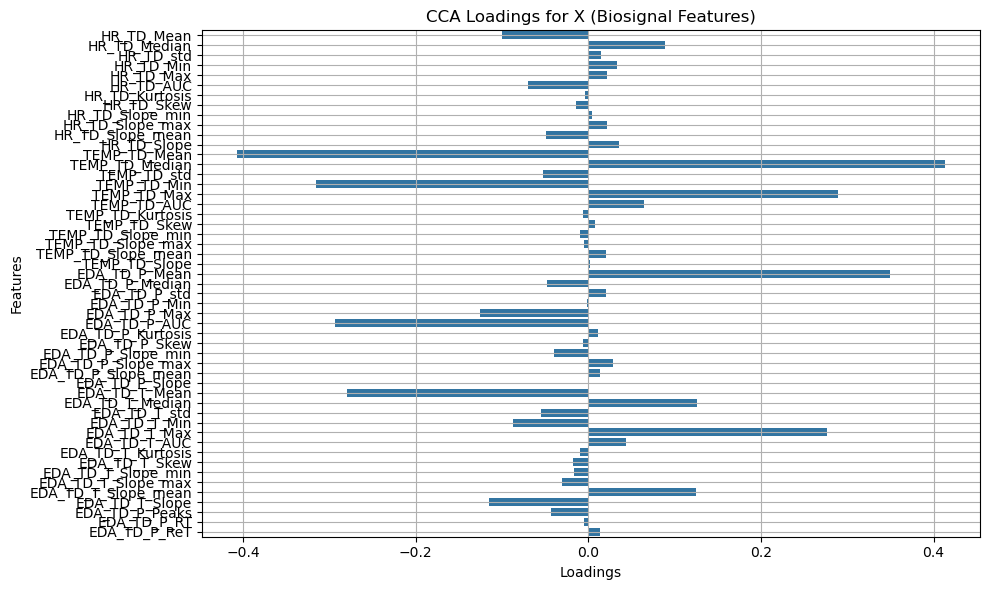

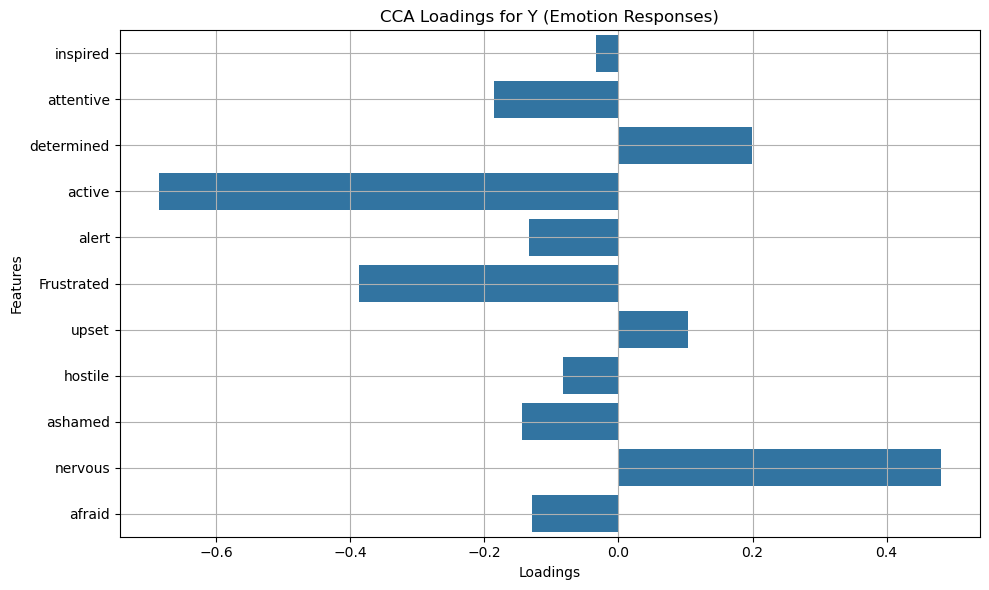

In [80]:
# Plot the loadings of the first canonical variables
def plot_loadings(cca, feature_names, weights='x', component=0, title=""):
    if weights == 'x':
        loadings = cca.x_weights_[:, component]
    elif weights == 'y':
        loadings = cca.y_weights_[:, component]
    else:
        raise ValueError("weights must be 'x' or 'y'")

    if len(loadings) != len(feature_names):
        raise ValueError("Mismatch between number of loadings and feature names.")
        
    plt.figure(figsize=(10, 6))
    sns.barplot(x=loadings, y=feature_names)
    plt.title(title)
    plt.xlabel("Loadings")
    plt.ylabel("Features")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# For X (biosignal features)
plot_loadings(cca, feature_cols, weights='x', title="CCA Loadings for X (Biosignal Features)")

# For Y (emotion responses)
plot_loadings(cca, emotion_cols, weights='y', title="CCA Loadings for Y (Emotion Responses)")

## CCA Per Phase

In [81]:
# Printing the Phase Column
print("Phase Column:")
print(data['Phase'].unique())

Phase Column:
['phase3' 'phase2' 'phase1']


Running CCA for phase: Pre
Canonical correlations: [0.91]


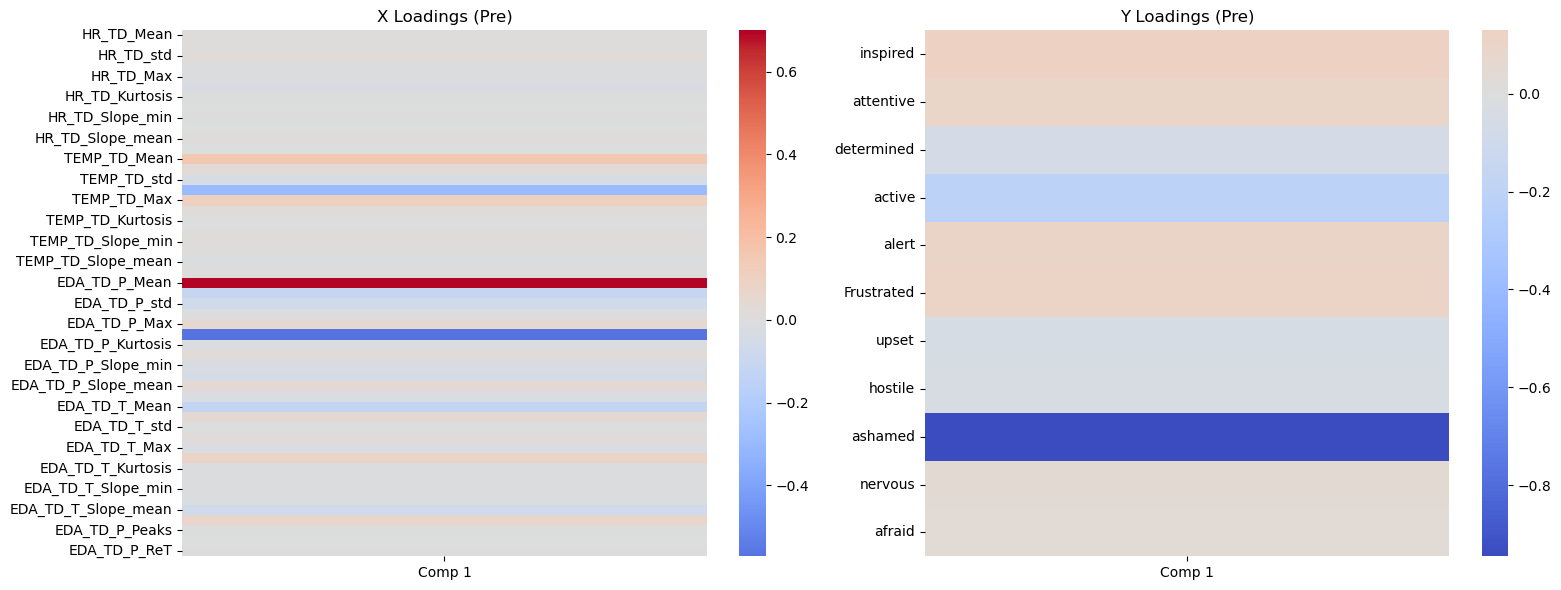

Running CCA for phase: Puzzle
Canonical correlations: [0.898]


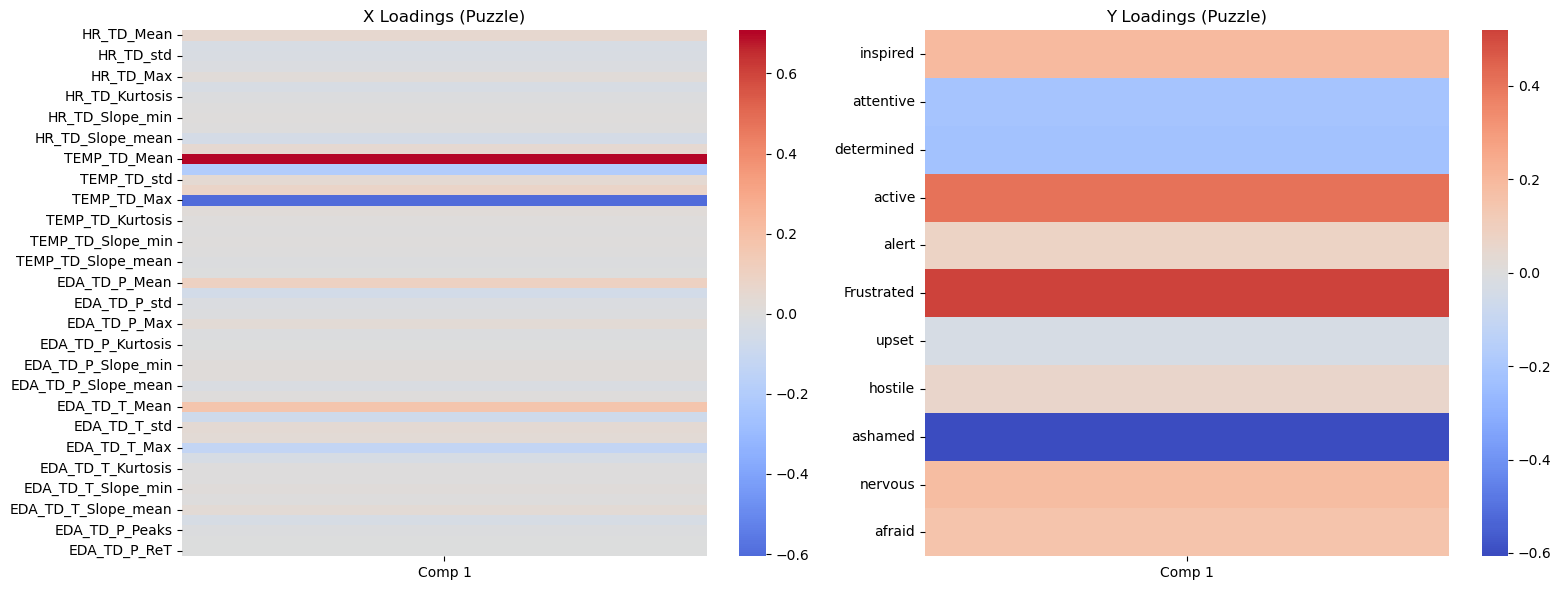

Running CCA for phase: Post
Canonical correlations: [0.91]


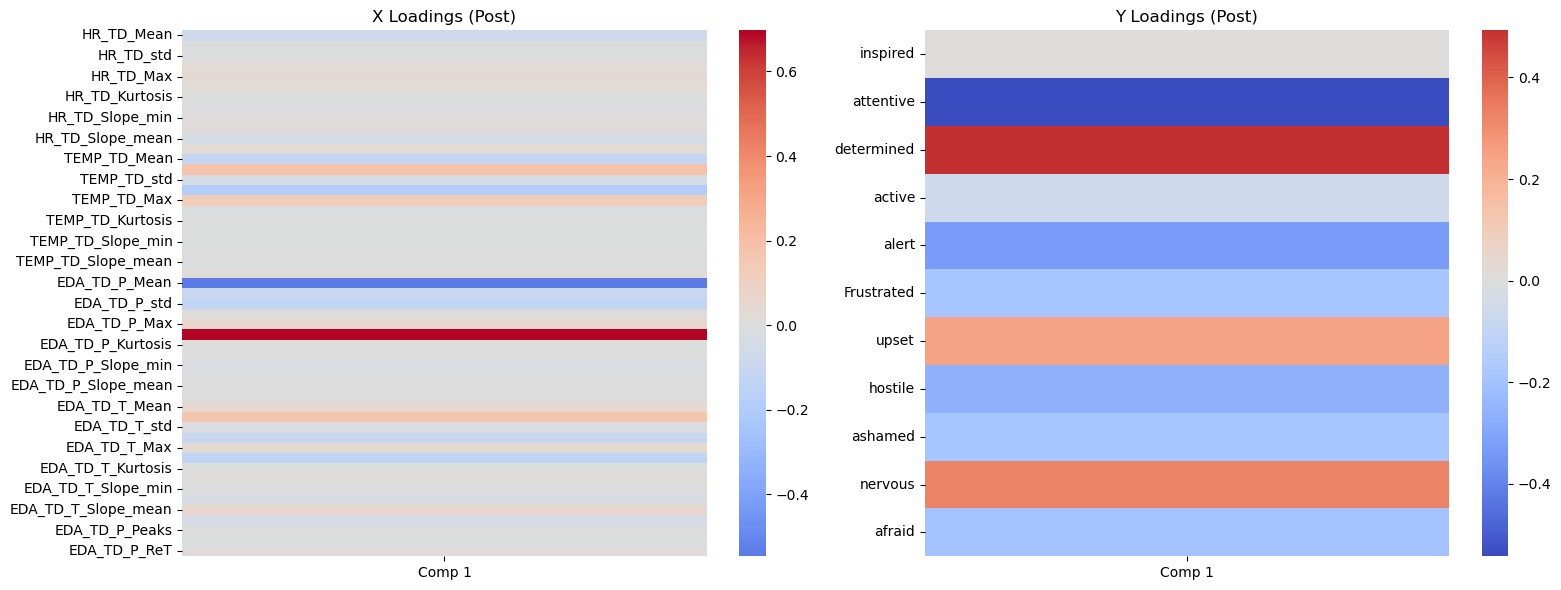

In [82]:
# Clean dataset
data = data.dropna(subset=feature_cols + emotion_cols)

# Rename phase values if needed (optional)
phase_map = {
    'phase1': 'Pre',
    'phase2': 'Puzzle',
    'phase3': 'Post'
}
data['Phase'] = data['Phase'].map(phase_map)

# Function to run CCA for a specific phase and plot loadings
def run_cca_per_phase(df, phase, n_components=1):
    print(f"Running CCA for phase: {phase}")
    
    df_phase = df[df['Phase'] == phase]
    
    # Feature matrix X and emotion matrix Y
    X = df_phase[feature_cols].values
    Y = df_phase[emotion_cols].values
    
    # Standardize
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)

    # Run CCA
    cca = CCA(n_components=n_components)
    cca.fit(X_scaled, Y_scaled)
    X_c, Y_c = cca.transform(X_scaled, Y_scaled)
    
    # Canonical correlations
    corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_components)]
    print("Canonical correlations:", np.round(corrs, 3))
    
    # Heatmap of loadings
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pd.DataFrame(cca.x_weights_, index=feature_cols, 
                             columns=[f"Comp {i+1}" for i in range(n_components)]),
                cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title(f"X Loadings ({phase})")

    sns.heatmap(pd.DataFrame(cca.y_weights_, index=emotion_cols, 
                             columns=[f"Comp {i+1}" for i in range(n_components)]),
                cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title(f"Y Loadings ({phase})")

    plt.tight_layout()
    plt.show()

# Run CCA for each phase
for phase in ['Pre', 'Puzzle', 'Post']:
    run_cca_per_phase(data, phase, n_components=1)